In [1]:
import numpy as np
import scipy as sp
import glob,os
%pylab inline --no-import-all
plt.rc('font', family='serif', serif='Times',size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure',titlesize=25)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['axes.linewidth'] = 2.
from astropy.io import fits
import astropy.units as u
import astropy.constants as c
import pandas as pd
import logging as log
from crispy.tools.initLogger import getLogger
log = getLogger('main')
from crispy.tools.image import Image
os.chdir('/Users/mrizzo/IFS/crispy/crispy/WFIRST/')
from params import Params
par = Params()
par.hdr

offaxis_psf_filename='/Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits'
folder = '/Users/mrizzo/IFS/Extraction/'
try:
    os.makedirs(folder)
except OSError:
    log.error("Couldn't create master folder")
    pass

from crispy.tools.postprocessing import process_offaxis
import glob
filelist = glob.glob('/Users/mrizzo/IFS/OS5/with_lowfc/*.fits')
reffiles = filelist[:30]
fileshape = fits.open(reffiles[0])[0].data.shape
BW=0.18
lamc=660
lamlist = lamc*np.linspace(1.-BW/2.,1.+BW/2.,fileshape[0])*u.nm

Populating the interactive namespace from numpy and matplotlib
main - ERROR - Couldn't create master folder


In [2]:
process_offaxis(par,
                offaxis_psf_filename=offaxis_psf_filename,
                fileshape=fileshape,
                lamlist=lamlist,lamc=lamc,
                outdir_average=folder,
                Nave=1,inttime=1,Nreads=1,
                filename=par.codeRoot+'/Inputs/'+'Jupiter_1x_5AU_90deg.dat',
                planet_radius = 1.27, # in R_jup
                planet_AU = 3.6,planet_dist_pc=14.1,
                albedo=0.28,
                target_star_T=5887*u.K, target_star_Vmag=5.03,
                ref_star_T=9377*u.K, ref_star_Vmag=2.37,
                tel_pupil_area=3.650265060424805*u.m**2, order=3,
                useQE=False,polychromeOut=True)

crispy - INFO - Recentering off-axis cube
crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits
crispy - INFO - The number of input pixels per lenslet is 5.000000
crispy - INFO - Writing data to /Users/mrizzo/IFS/Extraction//offaxiscube.fits
crispy - INFO - Constructing off-axis cube at planet separation: 4.44 lam/D (0.26 arcsec, 8.89 lenslets)
crispy - INFO - Writing data to /Users/mrizzo/IFS/Extraction//offaxiscube_shifted.fits
crispy - INFO - The number of input pixels per lenslet is 5.000000
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Writing data to ..//SimResults/detectorFramepoly.fits
crispy - INFO - Writing data to ..//SimResults/detectorFrame.fits
crispy - INFO - Done.
crispy - INFO - Performance: 43 seconds total
crispy - INFO - Writing data to /Users/mrizzo/IFS/Extraction//offaxis_star.fits
crispy 

<crispy.tools.image.Image instance at 0x10491d5a8>

0.0193086


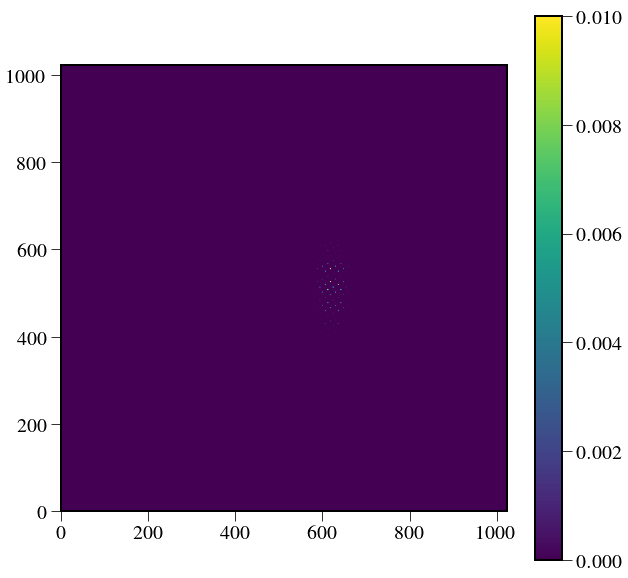

In [3]:
PSF_cube = fits.open(folder+'/PSF_cube.fits')[1].data
PSF_cube_cut = PSF_cube.copy()
PSF = np.zeros_like(PSF_cube_cut)
for i in range(PSF.shape[0]):
    PSF[i] = PSF_cube_cut[i]/np.sum(PSF_cube_cut[i])
print np.amax(PSF[0])
plt.figure(figsize=(10,10))
plt.imshow(PSF[0],vmax=0.01)
plt.colorbar()

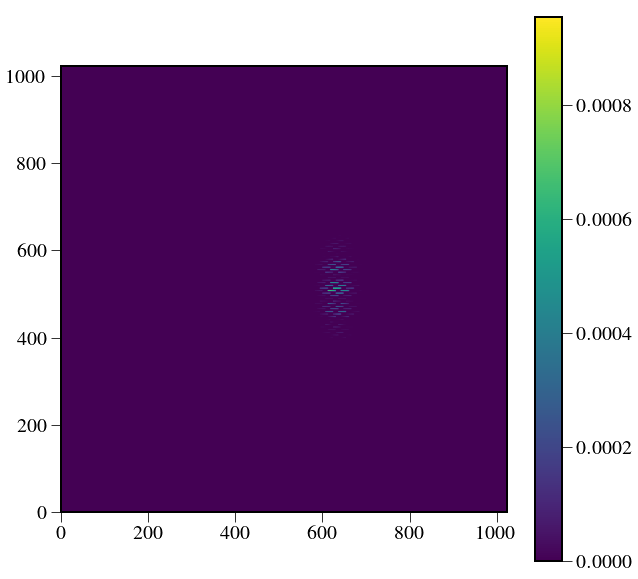

In [5]:
img = fits.open(folder+'offaxis_planet_detector.fits')[1].data
imgstar = fits.open(folder+'offaxis_star_detector.fits')[1].data
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.colorbar()

In [10]:
from crispy.tools.reduction import RL,calculateWaveList
psflets_flat = np.reshape(PSF, (PSF.shape[0], -1))
spec = RL(img,psflets_flat,niter=100)[0]
star = RL(imgstar,psflets_flat,niter=100)[0]

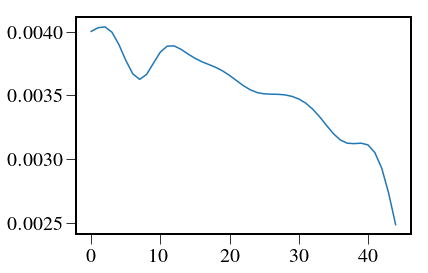

In [11]:
plt.plot(spec)

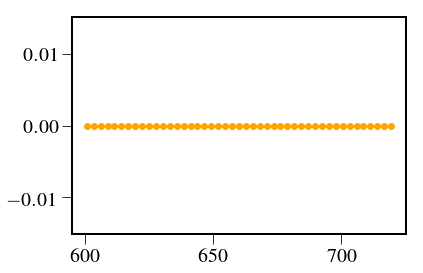

In [11]:
plt.plot(lamlist,spec/star)
from crispy.tools.inputScene import calc_contrast
contrast=calc_contrast(wavelist=lamlist.value,distance=3.6,radius=1.27,filename=par.codeRoot+'/Inputs/'+'Jupiter_1x_5AU_90deg.dat',albedo=0.28)
plt.scatter(lamlist,contrast,color='orange')

In [9]:
from crispy.IFS import reduceIFSMap
niter=1
imgRES = reduceIFSMap(par,img,method='lstsq_conv',smoothbad = False,fitbkgnd=False,niter=niter)
imgStar = reduceIFSMap(par,imgstar,method='lstsq_conv',smoothbad = False,fitbkgnd=False,niter=niter)

crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180119-170600_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/20180119-170600_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 11.861826s
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180119-170612_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/20180119-170612_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 11.517492s


crispy - INFO - Writing data to /Users/mrizzo/IFS/Extraction/planet_cube.fits
crispy - INFO - Writing data to /Users/mrizzo/IFS/Extraction/star_cube.fits


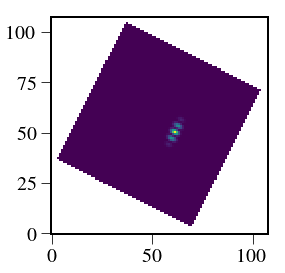

In [10]:
plt.imshow(imgRES.data[8])
imgRES.write(folder+'planet_cube.fits')
imgStar.write(folder+'star_cube.fits')

In [11]:
from crispy.tools.postprocessing import construct_mflib,convolved_mf
from crispy.tools.imgtools import bowtie
ydim,xdim = imgRES.data[0].shape
IWA=3
OWA=9
mask,scratch = bowtie(imgRES.data[0],ydim//2-1,xdim//2,openingAngle=65,
        clocking=-par.philens*180./np.pi,
        IWApix=IWA*lamc/par.lenslet_wav/par.lenslet_sampling,
        OWApix=OWA*lamc/par.lenslet_wav/par.lenslet_sampling,
        export=None,twomasks=False)    

construct_mflib(par,planet_cube=folder+'planet_cube.fits',
                threshold=0.2,
                lamc=lamc,
                BW=BW,
                outdir=folder,
                mask=mask,
                trim=30,
                outname = 'mflib.fits.gz',
                order=3)
mflib = folder+'mflib.fits.gz'

crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/Extraction/planet_cube.fits
crispy - INFO - Read inverse variance from HDU 2 of /Users/mrizzo/IFS/Extraction/planet_cube.fits
crispy - INFO - Coordinates of the planet in lenslets: 61.00, 50.00


In [12]:
convolved = convolved_mf(imgRES.data,mflib)
convolvedstar = convolved_mf(imgStar.data,mflib)
yp,xp = np.unravel_index(np.nanargmax(convolved[convolved.shape[0]//2]), convolved[convolved.shape[0]//2].shape)
log.info("Coordinates of the planet in lenslets: %.2f, %.2f" %(xp,yp))
signal = convolved[:,yp,xp]
star = convolvedstar[:,yp,xp]

main - INFO - Coordinates of the planet in lenslets: 61.00, 50.00


crispy - INFO - Reduced cube will have 19 wavelength bins


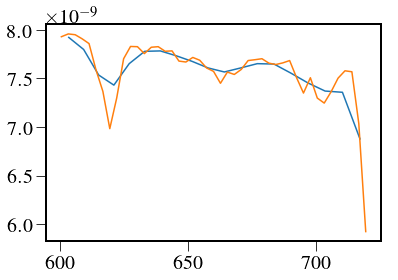

In [14]:
from crispy.tools.reduction import calculateWaveList
lam_midpts,lam_endpts = calculateWaveList(par)
from crispy.tools.inputScene import calc_contrast
contrast=calc_contrast(wavelist=lamlist.value,distance=3.6,radius=1.27,filename=par.codeRoot+'/Inputs/'+'Jupiter_1x_5AU_90deg.dat',albedo=0.28)

plt.plot(lam_midpts,signal/star)
plt.plot(lamlist.value,contrast)

In [15]:
par.npixperdlam = 2.0
imgOptExt = reduceIFSMap(par,img,method='optext',smoothbad = False,fitbkgnd=False,niter=niter)

ydim,xdim = imgOptExt.data[0].shape
IWA=3
OWA=9
mask,scratch = bowtie(imgOptExt.data[0],ydim//2-1,xdim//2,openingAngle=65,
        clocking=-par.philens*180./np.pi,
        IWApix=IWA*lamc/par.lenslet_wav/par.lenslet_sampling,
        OWApix=OWA*lamc/par.lenslet_wav/par.lenslet_sampling,
        export=None,twomasks=False)    
imgOptExt.write(folder+'planet_cube_optext.fits')
construct_mflib(par,planet_cube=folder+'planet_cube_optext.fits',
                threshold=0.2,
                lamc=lamc,
                BW=BW,
                outdir=folder,
                mask=mask,
                trim=30,
                outname = 'mflib_optext.fits.gz',
                order=3)
mflibOptExt = folder+'mflib_optext.fits.gz'
imgOptExt = reduceIFSMap(par,img,method='optext',smoothbad = False,fitbkgnd=False,niter=niter)
imgStarOptExt = reduceIFSMap(par,imgstar,method='optext',smoothbad = False,fitbkgnd=False,niter=niter)
convolvedOptext = convolved_mf(imgOptExt.data,mflibOptExt)
convolvedStarOptext = convolved_mf(imgStarOptExt.data,mflibOptExt)
signalOptext = convolvedOptext[:,yp,xp]
signalStarOptext = convolvedStarOptext[:,yp,xp]

crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Elapsed time: 1.884929s
crispy - INFO - Writing data to /Users/mrizzo/IFS/Extraction/planet_cube_optext.fits
crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/Extraction/planet_cube_optext.fits
crispy - INFO - Read inverse variance from HDU 2 of /Users/mrizzo/IFS/Extraction/planet_cube_optext.fits
crispy - INFO - Coordinates of the planet in lenslets: 61.00, 50.00
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Elapsed time: 1.540007s
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Elapsed time: 1.519300s


crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Reduced cube will have 19 wavelength bins


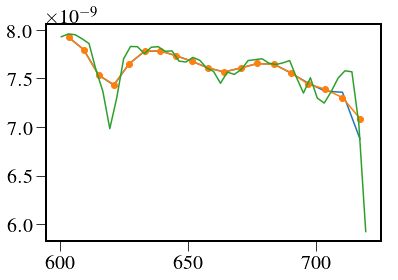

In [16]:
lam_midpts,lam_endpts = calculateWaveList(par,method='lstsq')
plt.plot(lam_midpts,signal/star)
lam_midpts,lam_endpts = calculateWaveList(par,method='optext')
plt.plot(lam_midpts,signalOptext/signalStarOptext,'-o')
plt.plot(lamlist.value,contrast)

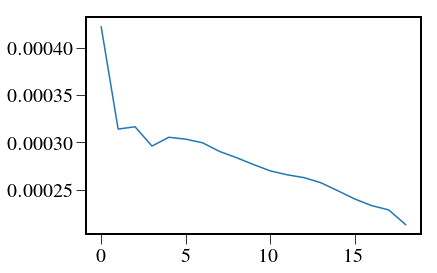

In [17]:
plt.plot(signal)

In [18]:
def SNR_microspectra(par,Nelec,img,Ntrials,niter):
    S = np.zeros((19,Ntrials))
    # construct appropriate image
    imgsum = np.sum(img)
    for i in range(Ntrials):
        poissonImage = np.random.poisson(img*Nelec/imgsum).astype(float)
        imgout = reduceIFSMap(par,poissonImage,method='lstsq_conv',smoothbad = False,fitbkgnd=False,niter=niter)
        convolved = convolved_mf(imgout.data,mflib)
        yp,xp = np.unravel_index(np.nanargmax(convolved[convolved.shape[0]//2]), convolved[convolved.shape[0]//2].shape)
        S[:,i] = convolved[:,yp,xp]
    plt.figure(figsize=(10,10))
    plt.imshow(poissonImage[400:620,570:690])
    plt.colorbar()
    return S


crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180119-170738_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/20180119-170738_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 11.878977s
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180119-170753_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/20180119-170753_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 11.297049s
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180119-170808_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/20180119-170808_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 11.364696s
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180119-170822_red_lstsq_conv_resid.fits
crispy - INFO - Writin

crispy - INFO - Elapsed time: 11.392805s
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180119-171452_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/20180119-171452_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 11.430919s
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180119-171507_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/20180119-171507_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 11.458021s
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180119-171521_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/20180119-171521_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 11.650235s
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180119-171536_red_lst

crispy - INFO - Writing data to ..//SimResults/20180119-172156_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 11.809900s
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180119-172211_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/20180119-172211_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 11.603763s
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180119-172225_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/20180119-172225_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 11.662348s
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180119-172240_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/20180119-172240_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 11.698763s
crispy - INFO - Reduced cube will have 

crispy - INFO - Writing data to ..//SimResults/20180119-172952_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/20180119-172952_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 12.134055s
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180119-173007_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/20180119-173007_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 12.055086s
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180119-173022_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/20180119-173022_red_lstsq_conv_model.fits
crispy - INFO - Elapsed time: 11.998202s
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ..//SimResults/20180119-173037_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/20180119-173037_red_lstsq_conv_mo

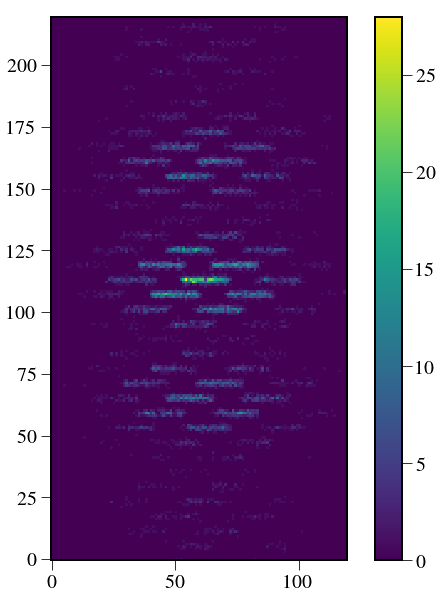

In [19]:
Nelec = 10000
Ntrials = 100
niter = 1
S = SNR_microspectra(par,Nelec,img,Ntrials,niter)

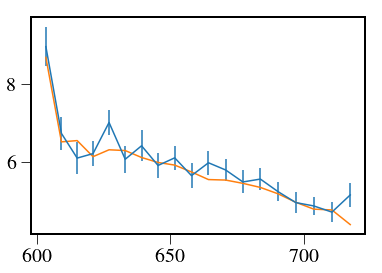

In [20]:
plt.errorbar(lam_midpts,S[:,-1],yerr=np.std(S,axis=1))
plt.plot(lam_midpts,np.mean(S,axis=1))

In [21]:
ave = 0.5*(S[9,:]+S[10,:])
ave = S[8,:]
print np.mean(ave)/np.std(ave)

19.2664655041


0.0180089


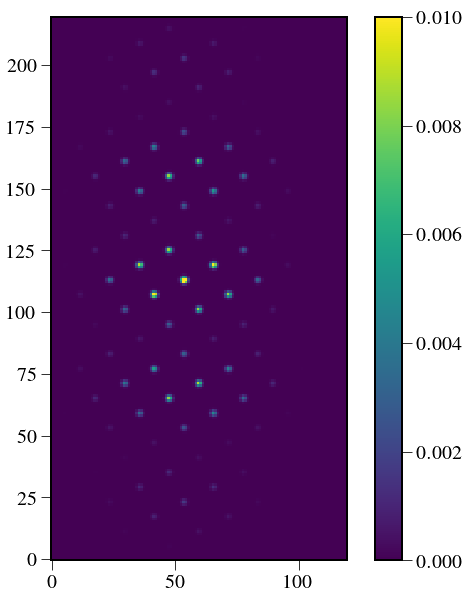

In [2]:

PSF_polychrome = fits.open(folder+'/PSF_polychrome.fits')[1].data
PSF_polychrome_cut = PSF_polychrome[:,400:620,570:690]
PSF = np.zeros_like(PSF_polychrome_cut)
for i in range(PSF.shape[0]):
    PSF[i] = PSF_polychrome_cut[i]/np.sum(PSF_polychrome_cut[i])
print np.amax(PSF[0])
plt.figure(figsize=(10,10))
plt.imshow(PSF[0],vmax=0.01)
plt.colorbar()

In [3]:
from crispy.tools.reduction import RL,calculateWaveList

def calcSNRtotal(Nelec,subim,psflet_subarr,pixnoise=0,npix=0,Niter=10000,plot=True,indspec=4,vect=None):
    #sumpsflets = subim*Nelec+pixnoise+1e-10
    N = psflet_subarr.shape[0]
    lstsq = np.zeros((N,Niter))
    varlstsq = np.zeros((N,Niter))
    Rvect = np.zeros((N,Niter))
    RLvals = np.zeros((N,Niter))

    psflets_flat = np.reshape(psflet_subarr, (psflet_subarr.shape[0], -1))
    A = psflets_flat.T

    for j in range(Niter):
        # subtract mean of background (assumed known)
        if j%(max(Niter/10,1))==0: print j,"/",Niter
#         Nit = np.amax((subim*Nelec+pixnoise)/0.1).astype(int)
#         if j%(max(Niter/10,1))==0: print j,"/",Niter,", Nit=",Nit

#         img = np.zeros_like(subim)
#         var = np.zeros_like(subim)
#         for h in range(Nit):
#             frame = np.random.poisson((subim*Nelec+pixnoise)/Nit.astype(float))
#             img+= frame
#             var += frame**2
#         var /= Nit.astype(float)
#         var -= (img/Nit.astype(float))**2
#         var*=Nit
#         img -= pixnoise
#         img = np.random.poisson(subim*Nelec+pixnoise)
        img = np.random.poisson(subim*Nelec/np.sum(subim)+pixnoise).astype(float)
    ### WATCH OUT, USING NELEC HERE IS CHEATING ###
        sumpix = np.sum(img-pixnoise)
        guess = np.ones(N)*sumpix/float(N)
        
        rl = RL(img,psflets=psflet_subarr,prior=pixnoise,guess=guess,niter=1)[0]#np.dot(R,RL(img,psflets=psflet_subarr)[0])
        RLvals[:,j] = rl
        variance = np.reshape(np.sum(psflet_subarr*rl[:,np.newaxis,np.newaxis],axis=0)+pixnoise,-1)
#         variance = np.reshape(img,-1)
        img -= pixnoise

#         variance = np.reshape(var,-1)
#         variance = np.reshape(img,-1)
#         img-=pixnoise
        Ninv = np.diag(1./(variance+1e-10))
        Cinv = np.dot(np.transpose(A),np.dot(Ninv,A))
        C = np.linalg.inv(Cinv)
        Q = sp.linalg.sqrtm(Cinv)
        s = np.sum(Q,axis=0)
        R = Q/s[:,np.newaxis]
        #Ctilde = np.diag(1./(s**2+1e-10)
        varlstsq[:,j] = 1./(s**2+1e-10)
        x = np.reshape(img,-1)
        right = np.dot(np.transpose(A),np.dot(Ninv,x))
        f = np.dot(C,right)
#         rl = RL(img,psflets=psflet_subarr)[0]#np.dot(R,RL(img,psflets=psflet_subarr)[0])
#         RLvals[:,j] = rl
        
#         lstsq[:,j] = np.dot(C,right)#np.dot(R,f)
        lstsq[:,j] = np.dot(R,f)
        #RLvals[:,j] = RL(img+pixnoise,psflets=psflet_subarr,prior=pixnoise,guess=lstsq[:,j],niter=10)[0]#np.dot(R,RL(img,psflets=psflet_subarr)[0])

#         RLvals[:,j] = np.dot(R,RLvals[:,j])
        if vect is not None: Rvect[:,j] = np.dot(R,vect)


    estSNRlstsq = np.mean(lstsq,axis=1)/np.std(lstsq,axis=1)
    estSNRRL = np.mean(RLvals,axis=1)/np.std(RLvals,axis=1)
#     estSNROptExt = np.mean(0.5*(optext[13,:]+optext[14,:]))/np.std(0.5*(optext[13,:]+optext[14,:]))
    if plot:
        plt.figure(figsize=(10,10))
        plt.imshow(img)
        plt.colorbar()
        plt.figure(figsize=(15,10))
        plt.subplot(121)
        res = img-np.reshape(np.dot(A,lstsq[:,j]),subim.shape)
        plt.imshow(res)
        Npix = np.prod(res.shape)
        plt.title('Residuals with lstsq algorithm: $\chi^2$=%.2f'%np.sum(res**2/np.reshape(np.dot(A,lstsq[:,j])+pixnoise,subim.shape)/Npix))

        plt.colorbar(fraction=0.046, pad=0.04)
        plt.subplot(122)
        res = img-np.reshape(np.dot(A,RLvals[:,j]),subim.shape)
        plt.imshow(res)
        plt.title('Residuals with EM algorithm: $\chi^2$=%.2f'%np.sum(res**2/np.reshape(np.dot(A,RLvals[:,j])+pixnoise,subim.shape)/Npix))
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.figure(figsize=(15,10))
#         plt.subplot(121)
#         lamlist,_ = calculateWaveList(par,method='lstsq')
#         plt.plot(lstsq[:,-1])
#         plt.plot(RLvals[:,-1])
#         scale = np.mean(RLvals[:,-1])/np.mean(optext[4:-4,-1])
#         plt.plot(lamlist,scale*optext[3:-3,-1])
#         print np.mean(RLvals[:,-1]),np.mean(optext[4:-4,-1])

        SNR = Nelec/(np.sqrt(Nelec+npix*pixnoise))
        print "Expected SNR:",np.mean(Rvect,axis=1)[indspec]/np.sqrt(np.mean(Rvect,axis=1)[indspec]+npix*pixnoise)
        print "Estimated SNR lstsq:",estSNRlstsq[indspec]
        print "Estimated SNR RL:",estSNRRL[indspec]
        if vect is not None:
            varray = np.array(vect)+1e-10
            fchi2 = Rvect[:,-1]
#             plt.subplot(122)
            plt.plot(fchi2,label='Input')
#             plt.plot(lstsq[:,-1])
            plt.errorbar(np.arange(N),lstsq[:,-1],yerr=np.sqrt(varlstsq[:,-1]),label='last lstsq trial')
            plt.plot(np.arange(N),np.mean(lstsq,axis=1),'o',label='lstsq samp. mean')
            plt.fill_between(np.arange(N), np.mean(lstsq,axis=1)-np.std(lstsq,axis=1), np.mean(lstsq,axis=1)+np.std(lstsq,axis=1),alpha=0.3,facecolor='Gray',label='lstsq samp. 1sigma')
            plt.errorbar(np.arange(N),np.mean(RLvals,axis=1),yerr=np.std(RLvals,axis=1),fmt='o',label='EM samp. mean')
            plt.plot(RLvals[:,-1],label='last EM trial')
            plt.legend()
            
#             print "MSE lstsq:",np.sum((estSNRlstsq-fchi2)**2)/np.sum(fchi2**2)
#             print "MSE RL:",np.sum((estSNRRL-fchi2)**2)/np.sum(fchi2**2)
#             print "MSE lstsq estimated:",np.mean(np.sum((lstsq-Rvect)**2,axis=0)/np.sum(Rvect**2,axis=0))
#             print "MSE RL estimated:",np.mean(np.sum((RLvals-Rvect)**2,axis=0)/np.sum(Rvect**2,axis=0))
            print "Average $\chi^2$ lstsq estimated:",np.mean(np.sum((lstsq-Rvect)**2/varlstsq,axis=0))/N
            print "Average $\chi^2$ RL estimated:",np.mean(np.sum((RLvals-Rvect)**2/varlstsq,axis=0))/N
#             print "MSRE lstsq normalized:",np.std((estSNRlstsq-varray)/varray)
#             print "MSRE RL normalized:",np.std((estSNRRL-varray)/varray)
            
        
#         print "Estimated SNR OptExt:",estSNROptExt
        if vect is not None: print "Expected mean:",np.mean(Rvect[indspec])
        print "Estimated mean lstsq:",np.mean(lstsq,axis=1)[indspec]
        print "Estimated mean RL:",np.mean(RLvals,axis=1)[indspec]
#         print pd.DataFrame(R)
#         print np.sum(R,axis=0)
#         print R[0],np.sum(R[0])
#         print "Estimated mean:",np.mean(0.5*(optext[13,:]+optext[14,:]))

    return estSNRlstsq,estSNRRL,Rvect#,estSNROptExtS

0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
Expected SNR: nan
Estimated SNR lstsq: 22.2016504303
Estimated SNR RL: 38.5302377725
Estimated mean lstsq: 532.052537426
Estimated mean RL: 529.968623119


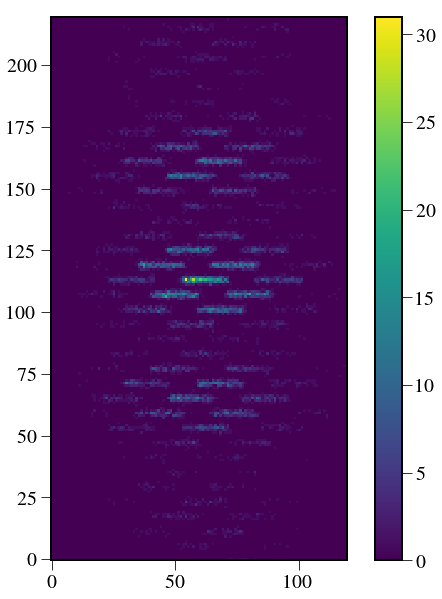

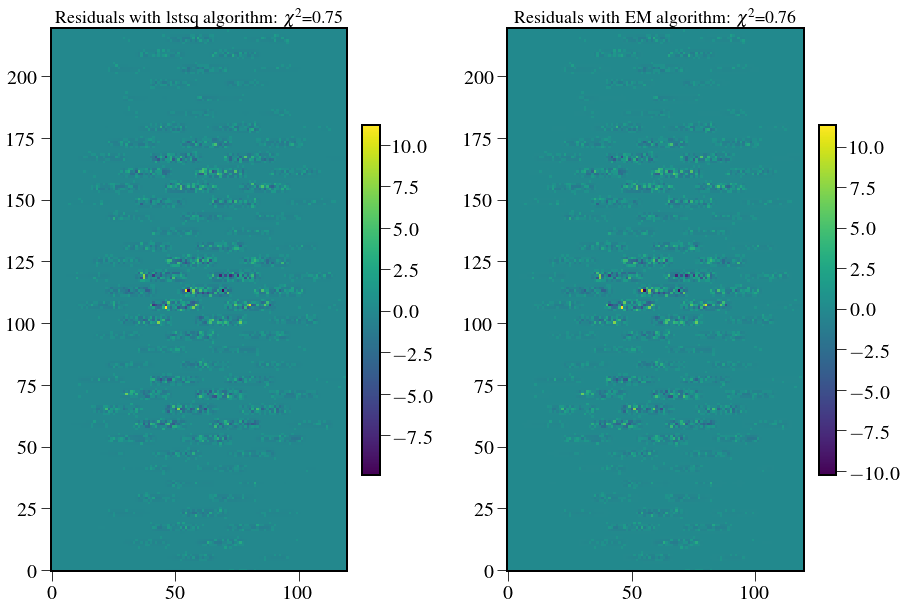

In [6]:
Nelec = 10000
Ntrials = 100
niter = 1

estSNRlstsq,estSNRRL,rvect=calcSNRtotal(Nelec=Nelec,
        subim=img[400:620,570:690],
        psflet_subarr=PSF,
        pixnoise=0.0,
        npix=28,
        plot=True,
        Niter=100,
        indspec=8,
        vect = None)